In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np
from numpy import genfromtxt
from tensorflow import keras
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.interpolate import CubicSpline
import keras.backend as K
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


state_dat_est=[]
state_dat_ref=[]
par_dat_est=[]
num_parameters=9
sampling_fact=30;  # defining factor
Fs=sampling_fact


horizon=5
for i in range(horizon):
    # Get States Data
    X_Dat=[]
    daty = genfromtxt("D:\Research_work\COVID_paper\My_covid_research\dataset_preprocessing\parameter_estim\input_new\states_ "+str(i)+" .csv", delimiter=',')
    days=daty[:,0]
    S=daty[:,1]
    I=daty[:,2]
    Q=daty[:,3]
    R=daty[:,4]
    D=daty[:,5]
    

    if i==0:
        init_cond=[S[0],I[0],Q[0],R[0],D[0]]
    else:
        temp_s=state_dat_est[len(state_dat_est)-1]
        
        init_cond=[temp_s[2,0],temp_s[2,1],temp_s[2,2],temp_s[2,3],temp_s[2,4]]

    S_ref=S
    I_ref=I
    Q_ref=Q
    R_ref=R
    D_ref=D

    

    
    days_n=np.linspace(0,days[len(days)-1],len(days)*sampling_fact)

    c_S = CubicSpline(days,S)
    cubic_S=c_S(days_n)

    c_I = CubicSpline(days,I)
    cubic_I=c_I(days_n)

    c_Q = CubicSpline(days,Q)
    cubic_Q=c_Q(days_n)

    c_R = CubicSpline(days,D)
    cubic_R=c_R(days_n)

    c_D = CubicSpline(days,D)
    cubic_D=c_D(days_n)


    cubic_S=cubic_S[0:81]
    cubic_I=cubic_I[0:81]
    cubic_Q=cubic_Q[0:81]
    cubic_R=cubic_R[0:81]
    cubic_D=cubic_D[0:81]


    nc=1
    S = np.reshape(cubic_S, (-1, 9))
    pca = PCA(n_components=nc)
    S_new= pca.fit_transform(S).flatten()
    S_new=np.expand_dims(S_new, axis=0)

    I = np.reshape(cubic_I, (-1, 9))
    pca = PCA(n_components=nc)
    I_new= pca.fit_transform(I).flatten()
    I_new=np.expand_dims(I_new, axis=0)
    
    Q= np.reshape(cubic_Q, (-1, 9))
    pca = PCA(n_components=nc)
    Q_new= pca.fit_transform(Q).flatten()
    Q_new=np.expand_dims(Q_new, axis=0)

    R= np.reshape(cubic_R, (-1, 9))
    pca = PCA(n_components=nc)
    R_new= pca.fit_transform(R).flatten() 
    R_new=np.expand_dims(R_new, axis=0)

    D= np.reshape(cubic_D, (-1, 9))
    pca = PCA(n_components=nc)
    D_new= pca.fit_transform(D).flatten() 
    D_new=np.expand_dims(D_new, axis=0)

    #Also consider using the Hankel matrix
    #Also consider enlongate the vector two to three pc's



    #----------------------------------------------------------------------------------------------------------------------
    # my_dat=np.concatenate((S_new,I_new,Q_new,R_new,D_new),axis=0)
    # my_dat=np.transpose(my_dat)
    #----------------------------------------------------------------------------------------------------------------------

    my_dat=np.concatenate((np.transpose(S_new),np.transpose(I_new),np.transpose(Q_new),np.transpose(R_new),np.transpose(D_new)),axis=1)
    #----------------------------------------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------
    #Dimensions should be time x channels
    X_Dat.append(my_dat)

    X_datnew=np.asarray(X_Dat)

    X=X_datnew
    

    # Get my transformer model for parameter regression
    my_model_p = keras.models.load_model('approximator3.h5')
    out_p=my_model_p.predict(X)

    out_p_new=np.expand_dims(out_p, axis=2)
    my_model = keras.models.load_model('deformer.h5')
    out=my_model.predict(out_p_new)

    parameters=list(out[0])


    #Hybrid SIQRD model
    zeta=parameters[0]
    beta1=parameters[1]
    beta2=parameters[2]
    alpha1=parameters[3]
    alpha2=parameters[4]
    delta=parameters[5]
    Keta=parameters[6]
    to=parameters[7]
    gamma=parameters[8]




    N=sum(init_cond)
        

    def siqrd(states, t):

        S=states[0]
        I=states[1]
        Q=states[2]
        R=states[3]
        D=states[4]

        return [-zeta*(N-S)+gamma*R,
        zeta*(N-S)-beta1*(to-t)*I-beta2*I-Keta-delta*I,
        beta2*I+Keta-alpha2*Q-alpha1*Q,
        beta1*(to-t)*I+alpha1*Q-gamma*R,
        delta*I*D+alpha2*np.log(1+Q)]

    Fs=10
    days = np.linspace(0, 3, Fs*3)

    SIQRD = odeint(siqrd,init_cond,days)
    S= np.abs(SIQRD[::Fs,0])
    I = np.abs(SIQRD[::Fs,1])
    Q= np.abs(SIQRD[::Fs,2])
    R = np.abs(SIQRD[::Fs,3])
    D = np.abs(SIQRD[::Fs,4])
    days=days[::Fs]

    state_dater=np.stack((S,I,Q,R,D))
    state_dater=np.transpose(state_dater)

    state_rdater=np.stack((S_ref,I_ref,Q_ref,R_ref,D_ref))
    state_rdater=np.transpose(state_rdater)

    # para_dater=np.stack((alpha*np.ones(3),t1*np.ones(3),gamma1*np.ones(3),gamma2*np.ones(3),beta*np.ones(3)))
    # para_dater=np.stack((alpha*np.ones(3),beta*np.ones(3),gamma1*np.ones(3),gamma2*np.ones(3),delta*np.ones(3)))
    para_dater=np.stack((zeta*np.ones(3),beta1*np.ones(3),beta2*np.ones(3),alpha1*np.ones(3),alpha2*np.ones(3),delta*np.ones(3),Keta*np.ones(3),to*np.ones(3),gamma*np.ones(3)))
    para_dater=np.transpose(para_dater)


    state_dat_est.append(state_dater)
    state_dat_ref.append(state_rdater)
    par_dat_est.append(para_dater)




state_dat_est=np.vstack(state_dat_est)   
state_dat_ref=np.vstack(state_dat_ref)
par_dat_est=np.vstack(par_dat_est)

days=np.linspace(0,state_dat_est.shape[0]-1,state_dat_est.shape[0])



In [3]:
from itertools import chain
greek_codes   = chain(range(0x370, 0x3e2), range(0x3f0, 0x400))
greek_symbols = (chr(c) for c in greek_codes)
greek_letters = [c for c in greek_symbols if c.isalpha()]
my_letters=greek_letters[51:61]
para_names=[my_letters[5],my_letters[1]+str(1),my_letters[1]+str(2),my_letters[0]+str(1),my_letters[0]+str(2),my_letters[3],'K','to',my_letters[2]]
print("Parameter Names:")
print(para_names)

Parameter Names:
['ζ', 'β1', 'β2', 'α1', 'α2', 'δ', 'K', 'to', 'γ']


In [5]:
#read csv pd
extender=15
import pandas as pd
df=pd.read_excel('D:\Research_work\COVID_paper\My_covid_research2/validation/forecasting\covid_534days.xlsx')


dates=df['DATE'].tolist()

dates=dates[-16:-1]

df = pd.DataFrame({'DATE': dates, para_names[0]: par_dat_est[0:extender,0], para_names[1]: par_dat_est[0:extender,1], para_names[2]: par_dat_est[0:extender,2], para_names[3]: par_dat_est[0:extender,3], para_names[4]: par_dat_est[0:extender,4], para_names[5]: par_dat_est[0:extender,5],para_names[6]: par_dat_est[0:extender,6],para_names[7]: par_dat_est[0:extender,7],para_names[8]: par_dat_est[0:extender,8]})
df.set_index('DATE', inplace=True)

<AxesSubplot:xlabel='DATE'>

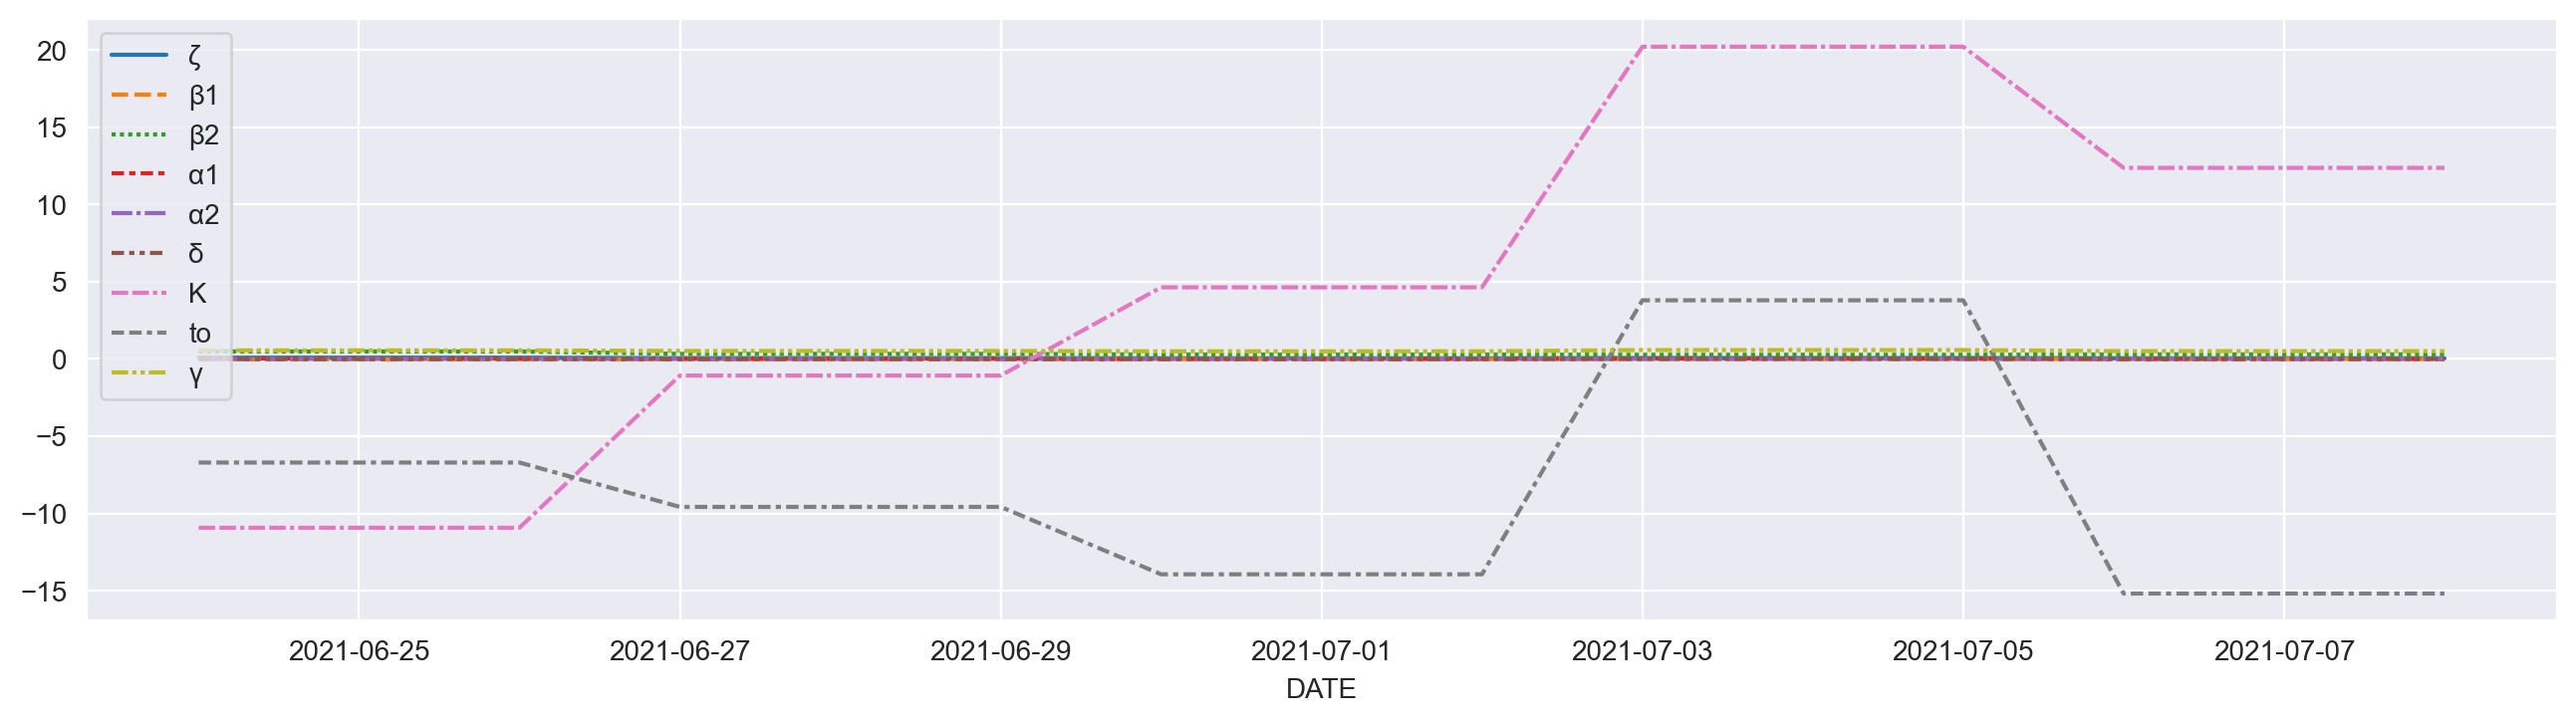

In [6]:
from matplotlib import pyplot
import seaborn as sns
pyplot.figure(figsize=(16, 4),dpi=200) # width and height in inches

sns.set_style('darkgrid')
sns.lineplot(data = df)

In [ ]:
#save parameter data
# np.savetxt('parameters_est.csv',par_dat_est,delimiter=',')